In [74]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [75]:
a = torch.tensor([[1,2],[3,4]])
b = torch.tensor([2, 3])
print('外积：', torch.matmul(a, b))
x = torch.tensor([1,2])
y = torch.tensor([3,4])
print('内积（点积）：', torch.dot(x, y))
print('哈德玛积：', x * y)

外积： tensor([ 8, 18])
内积（点积）： tensor(11)
哈德玛积： tensor([3, 8])


In [76]:
x = torch.arange(4.0)
x.requires_grad_(True)
y = 2 * torch.dot(x, x)
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

## 线性回归
1. 构造数据
2. 定义取数函数（小批量梯度下降需要随机取数）
2. 定义损失函数
3. 定义优化函数
4. 定义预测模型 $y=WX+b$
5. 进行多轮训练
6. 训练效果检测

### 构造数据
构造一个线性数据集，假设有两个变量
$y = w1 * x1 + w2 * x2 + b$

In [77]:
W = torch.tensor([5., 10])
b = 4.2
X = torch.normal(0, 1, (1000, 2))
noise = torch.normal(1, 0.1, (1, 1))
y = torch.matmul(X, W.reshape(2, 1)) + b
y +=  torch.normal(0, 0.01, y.shape)
print(X[0], y[0])

tensor([-0.5342, -1.2330]) tensor([-10.7807])


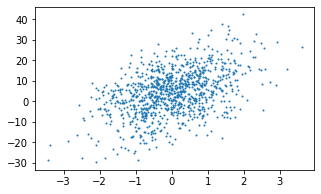

In [78]:
# 画图验证下y和x1之间是线性关系
fig, ax = plt.subplots(figsize=(5, 3))
ax.scatter(X[:, 0], y, s=1)

### 定义损失函数
平方损失 $loss = \frac{1}{2} * (y - yhat) ^ 2$

In [79]:
def loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 定义优化函数
梯度下降法向参数的真实值逼近

In [80]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 定义取数函数
小批量梯度下降法需要从数据集里随机取小批量的数据来进行训练

In [81]:
def get_data(data, res, batch_size):
    idx = list(range(len(data)))
    np.random.shuffle(idx)
    for i in range(0, len(idx), batch_size):
        indices = idx[i:i + batch_size]
        yield data[indices], res[indices]

### 定义模型

In [93]:
def linear_reg(X, W, b):
    return torch.matmul(X, W) + b

### 定义训练训练函数
求y_hat，然后调用损失函数，对参数求导

In [90]:
# 注意下两个train函数，本质的区别是 第一个只取3次值
# 第二个train 所有的值取一遍，循环三遍
def train(data, res, W, b, lr, epochs, batch_size):
    train_iter = get_data(data, res, batch_size)
    for i in range(epochs):
        train_data, res_data = next(train_iter)
        l = loss(linear_reg(train_data, W, b), res_data)
        l.sum().backward()
        sgd([W, b], lr, batch_size)
        with torch.no_grad():
            train_l = loss(linear_reg(train_data, W, b), res_data)
            print('epoch', i + 1, 'loss:', train_l.mean())

In [96]:
def train(data, res, W, b, lr, epochs, batch_size):
    for i in range(epochs):
        for train_data, res_data in get_data(data, res, batch_size):
            l = loss(linear_reg(train_data, W, b), res_data)
            l.sum().backward()
            sgd([W, b], lr, batch_size)
            print('w is', W.detach().numpy().reshape(1, -1))
        with torch.no_grad():
            train_l = loss(linear_reg(train_data, W, b), res_data)
            print(f'epoch, {i + 1}, loss:, {float(train_l.mean()):f}')

### 初始化变量开始训练

In [97]:
train_W = torch.normal(1, 0.1, (2, 1), requires_grad=True)
train_b = torch.zeros(1, requires_grad=True)
lr = 0.03
epochs = 3
batch_size = 10
train(X, y, train_W, train_b, lr, epochs, batch_size)

print(train_W.detach().numpy(), train_b.detach().numpy())


w is [[0.9427955 1.0027084]]
w is [[1.0612068 1.1014646]]
w is [[1.1079193 1.2406998]]
w is [[1.0963954 1.5252073]]
w is [[1.1171644 1.6285212]]
w is [[1.160728  1.6503353]]
w is [[1.3075079 1.8066338]]
w is [[1.443762  2.1214213]]
w is [[1.5571579 2.260409 ]]
w is [[1.8272438 2.4394863]]
w is [[1.8175098 2.495621 ]]
w is [[1.9774592 2.7748513]]
w is [[2.1116045 2.957442 ]]
w is [[2.1827273 3.1113832]]
w is [[2.2763107 3.316935 ]]
w is [[2.451178 3.593502]]
w is [[2.5694828 3.7337308]]
w is [[2.6806648 3.958171 ]]
w is [[2.9516778 4.403363 ]]
w is [[3.0214674 4.5340433]]
w is [[3.194646 4.626357]]
w is [[3.2443516 4.7478037]]
w is [[3.2902436 4.8737364]]
w is [[3.2345414 4.941155 ]]
w is [[3.2784216 5.081754 ]]
w is [[3.3851333 5.199899 ]]
w is [[3.4471989 5.3479414]]
w is [[3.4702678 5.5299373]]
w is [[3.5628347 5.6553483]]
w is [[3.5729406 5.7634206]]
w is [[3.546218  5.8385954]]
w is [[3.4740567 6.0147185]]
w is [[3.5120723 6.2340794]]
w is [[3.510368  6.3209314]]
w is [[3.4911098 6

### 和真实结果比较

In [53]:
test_iter = get_data(X, y, batch_size)
test_data, test_res = next(test_iter)
with torch.no_grad():
    y_hat = linear_reg(test_data, train_W, train_b)
    l = loss(test_res, y_hat) / batch_size
    print('loss: ', l.mean())

loss:  tensor(6.1466e-06)


In [56]:
y = torch.tensor([[0], [0], [1]])
y

tensor([[0],
        [0],
        [1]])

In [58]:
y_hat = torch.tensor([[2], [4], [3]])
y_hat

tensor([[2],
        [4],
        [3]])

In [60]:
def softmax(data):
    return torch.exp(data) / torch.exp(data).sum()
softmax(y_hat)

tensor([[0.0900],
        [0.6652],
        [0.2447]])

In [65]:
(torch.tensor([1, 2]) ** 2 / 2).sum()

tensor(2.5000)

In [67]:
(torch.tensor([[1, 2], [1, 2]]) ** 2 / 2).sum() / 2

tensor(2.5000)